In [16]:
import os
import sys

os.environ["JAVA_HOME"] = "JDK 8/Contents/Home"
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

In [17]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import pandas as pd
from pyspark.sql.types import StructType, StructField, StringType, IntegerType

In [18]:
spark = SparkSession.builder.appName("Data_Vis_Day_3").getOrCreate()

In [19]:
sns.set_theme(style="whitegrid")

In [20]:
import pandas as pd

# Load Titanic dataset from your local file
path = "/Users/tomdursley/Downloads/Titanic-Dataset.csv"  # Update this if the file is in a different directory
titanic_pd = pd.read_csv(path)


In [21]:
titanic_pd

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [22]:
titanic_spark_df = spark.createDataFrame(titanic_pd)
titanic_spark_df.show(5)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25|  NaN|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925|  NaN|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05|  NaN|       S|
+-----------+--------+------+--------------------+------+----+-----+-----+------

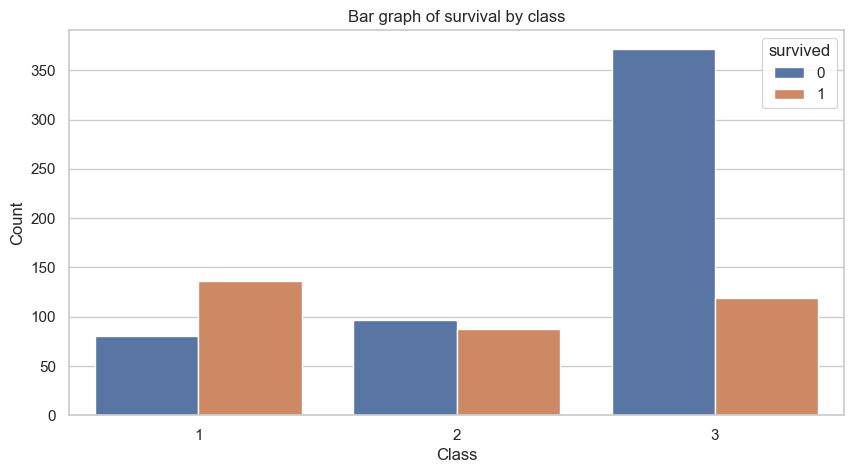

In [23]:
survival_count_df = titanic_spark_df.groupBy('Pclass', 'survived').count().toPandas()
plt.figure(figsize=(10, 5))
sns.barplot(data=survival_count_df, x='Pclass', y='count', hue='survived')
plt.title('Bar graph of survival by class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

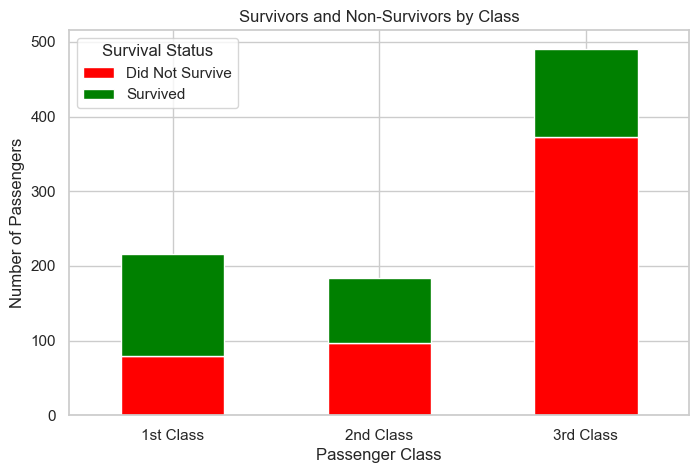

In [24]:
# Group by Passenger Class and Survival Status, then count occurrences
survival_counts = titanic_spark_df.groupBy("Pclass", "Survived").count()

# Convert to Pandas for easy plotting
survival_counts_pandas = survival_counts.toPandas()

# Pivot (like unstack in Pandas)
survival_counts_pivot = survival_counts_pandas.pivot(index="Pclass", columns="Survived", values="count")

# Rename columns for clarity
survival_counts_pivot.columns = ["Did Not Survive", "Survived"]

# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(8, 5))
survival_counts_pivot.plot(kind="bar", stacked=True, ax=ax, color=["red", "green"])

# Labels and Title
ax.set_xlabel("Passenger Class")
ax.set_ylabel("Number of Passengers")
ax.set_title("Survivors and Non-Survivors by Class")
ax.legend(title="Survival Status")

# Set X-axis labels
ax.set_xticklabels(["1st Class", "2nd Class", "3rd Class"], rotation=0)

# Show plot
plt.show()

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25|  NaN|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925|  NaN|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05|  NaN|       S|
+-----------+--------+------+--------------------+------+----+-----+-----+------

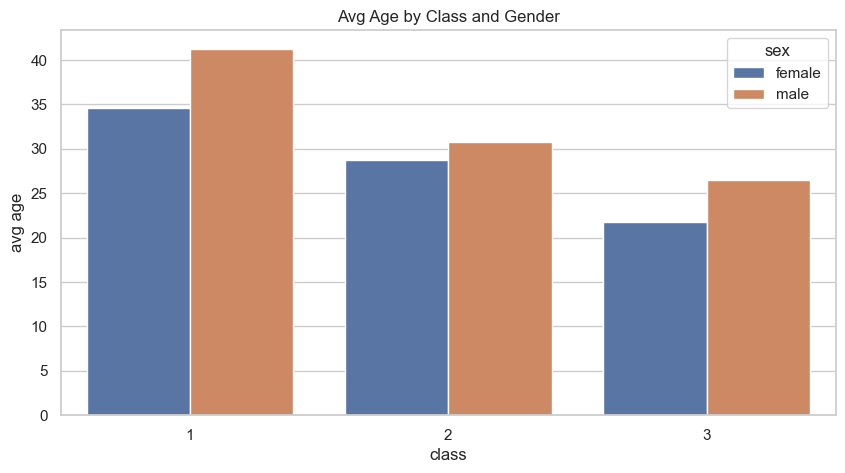

In [25]:
titanic_spark_df = spark.createDataFrame(titanic_pd).dropna()
titanic_spark_df.show(5)
age_stats_df = titanic_spark_df.groupBy('Pclass', 'sex').agg(round(avg('age'), 2).alias('avg_age')).toPandas()
plt.figure(figsize=(10, 5))
sns.barplot(data=age_stats_df, x='Pclass', y='avg_age', hue='sex')
plt.title('Avg Age by Class and Gender')
plt.xlabel('class')
plt.ylabel('avg age')
plt.show()

In [26]:
from pyspark.sql import functions as F


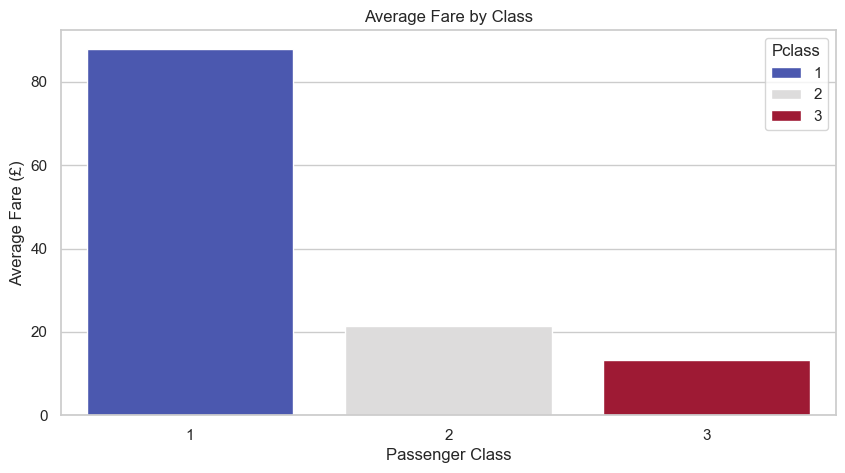

In [27]:
fare_stats_df = titanic_spark_df.groupBy("Pclass").agg(round(avg("Fare"), 2).alias("avg_fare")).toPandas()

plt.figure(figsize=(10, 5))
sns.barplot(data=fare_stats_df, x="Pclass", y="avg_fare", hue="Pclass", palette="coolwarm")

plt.title("Average Fare by Class")
plt.xlabel("Passenger Class")
plt.ylabel("Average Fare (£)")

plt.show()





In [28]:
num_columns = ["survived", "Pclass","fare", "age"]
titanic_numeric = titanic_spark_df.select(num_columns)
correlation = titanic_numeric.toPandas().corr()

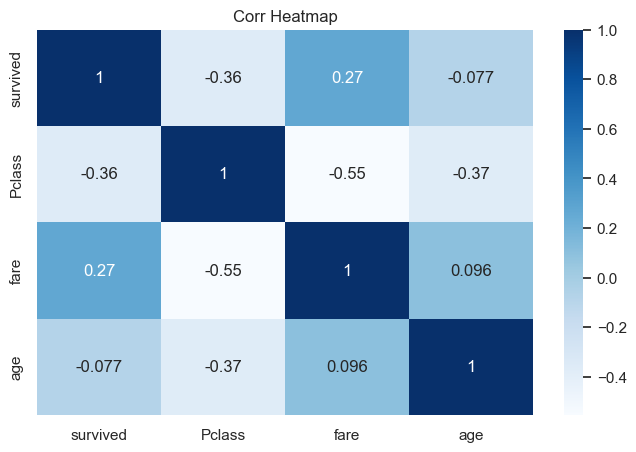

In [29]:
plt.figure(figsize=(8, 5))
sns.heatmap(correlation, annot=True, cmap="Blues")
plt.title("Corr Heatmap")
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 41.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 46.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


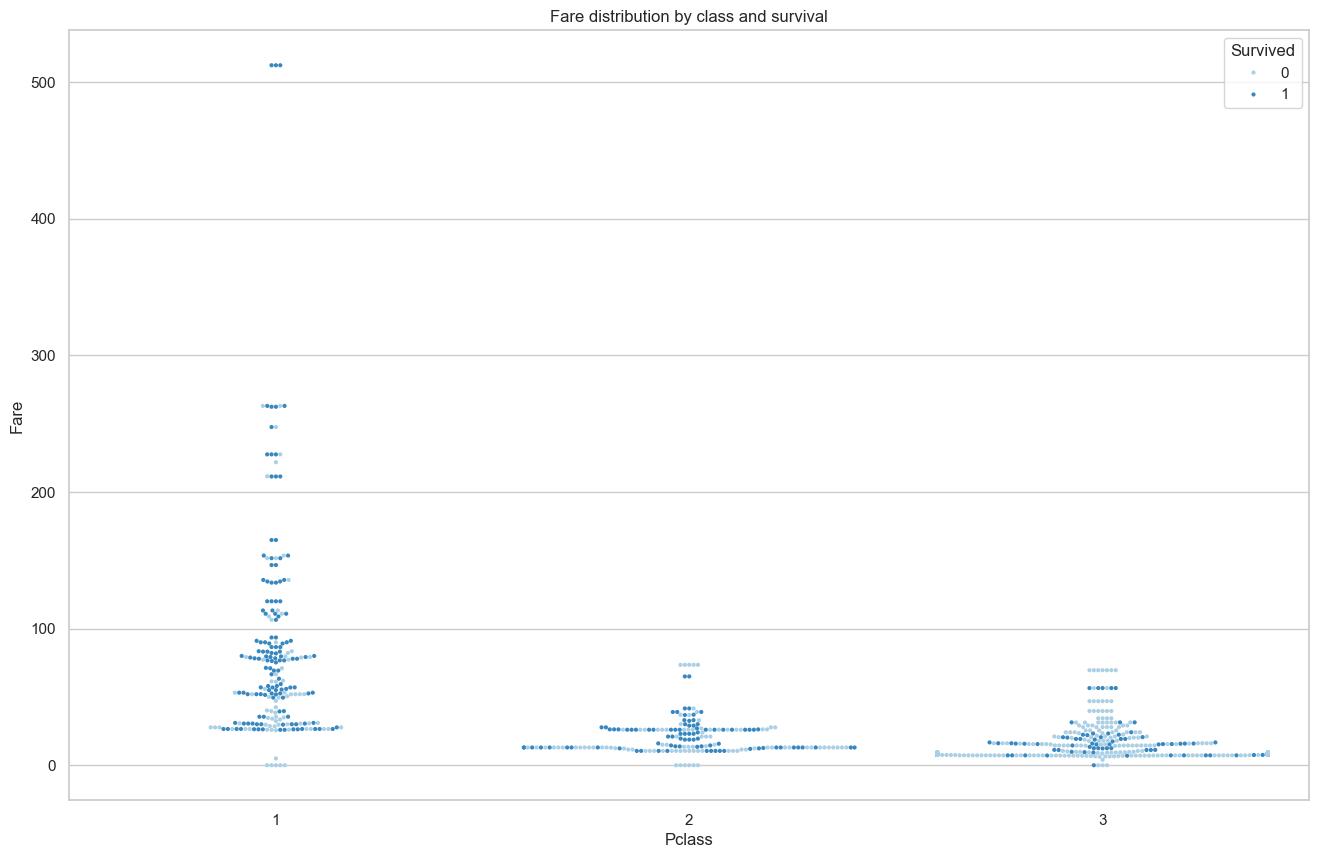

In [30]:
plt.figure(figsize=(16, 10))
sns.swarmplot(data=titanic_pd, x="Pclass", y="Fare", hue="Survived", palette="Blues", s=3)
plt.title("Fare distribution by class and survival")
plt.show()



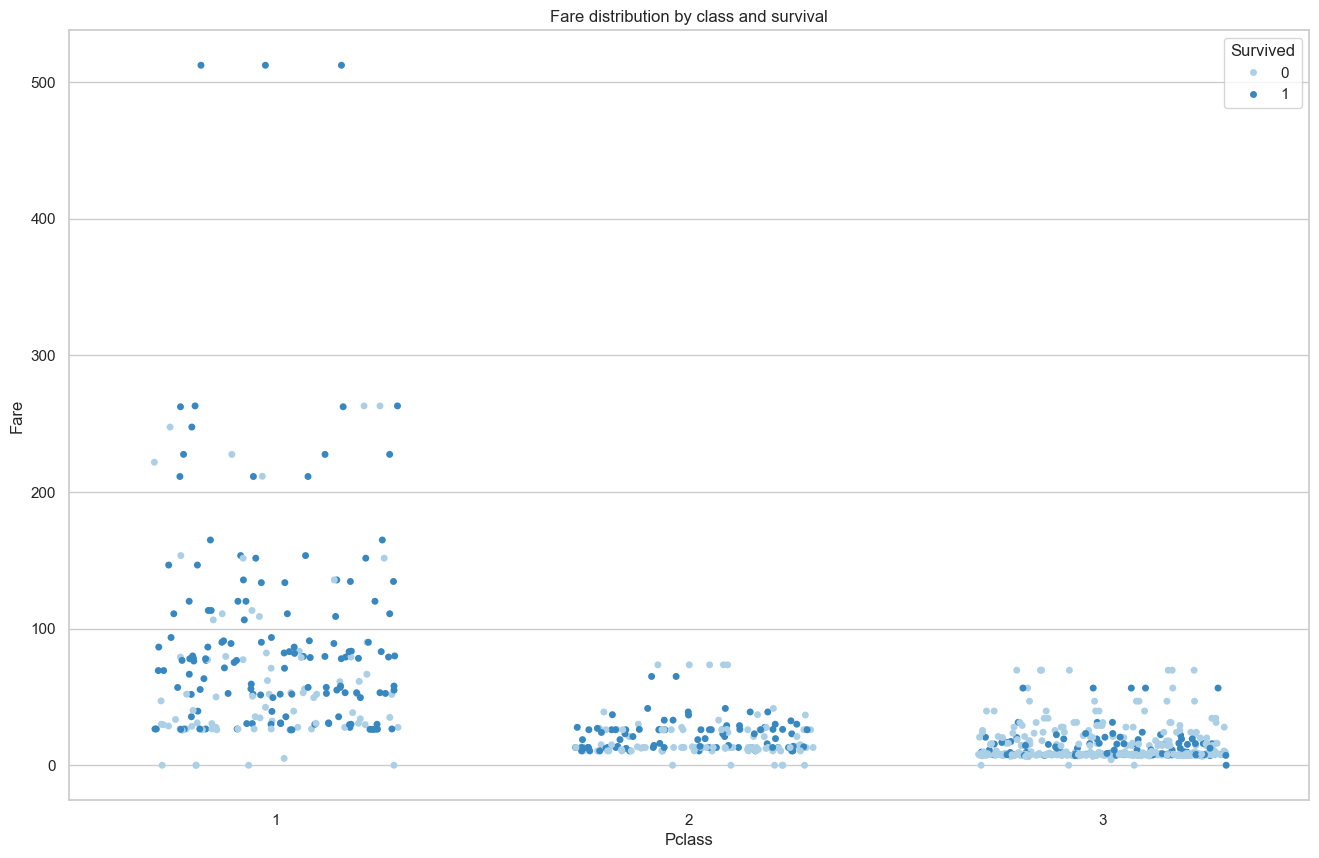

In [31]:
plt.figure(figsize=(16, 10))
sns.stripplot(data=titanic_pd, x="Pclass", y="Fare", hue="Survived", palette="Blues", jitter=0.3)
plt.title("Fare distribution by class and survival")
plt.show()


In [32]:
print(titanic_pd.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


<function matplotlib.pyplot.show(close=None, block=None)>

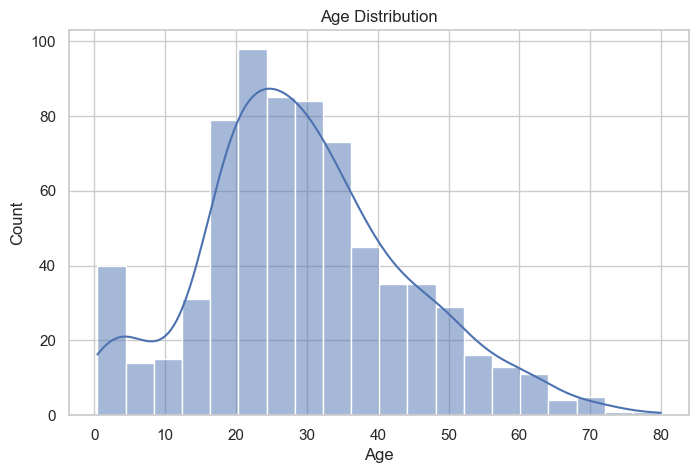

In [33]:
plt.figure(figsize=(8 ,5))
sns.histplot(titanic_pd['Age'].dropna(), kde=True)
plt.title("Age Distribution")
plt.show

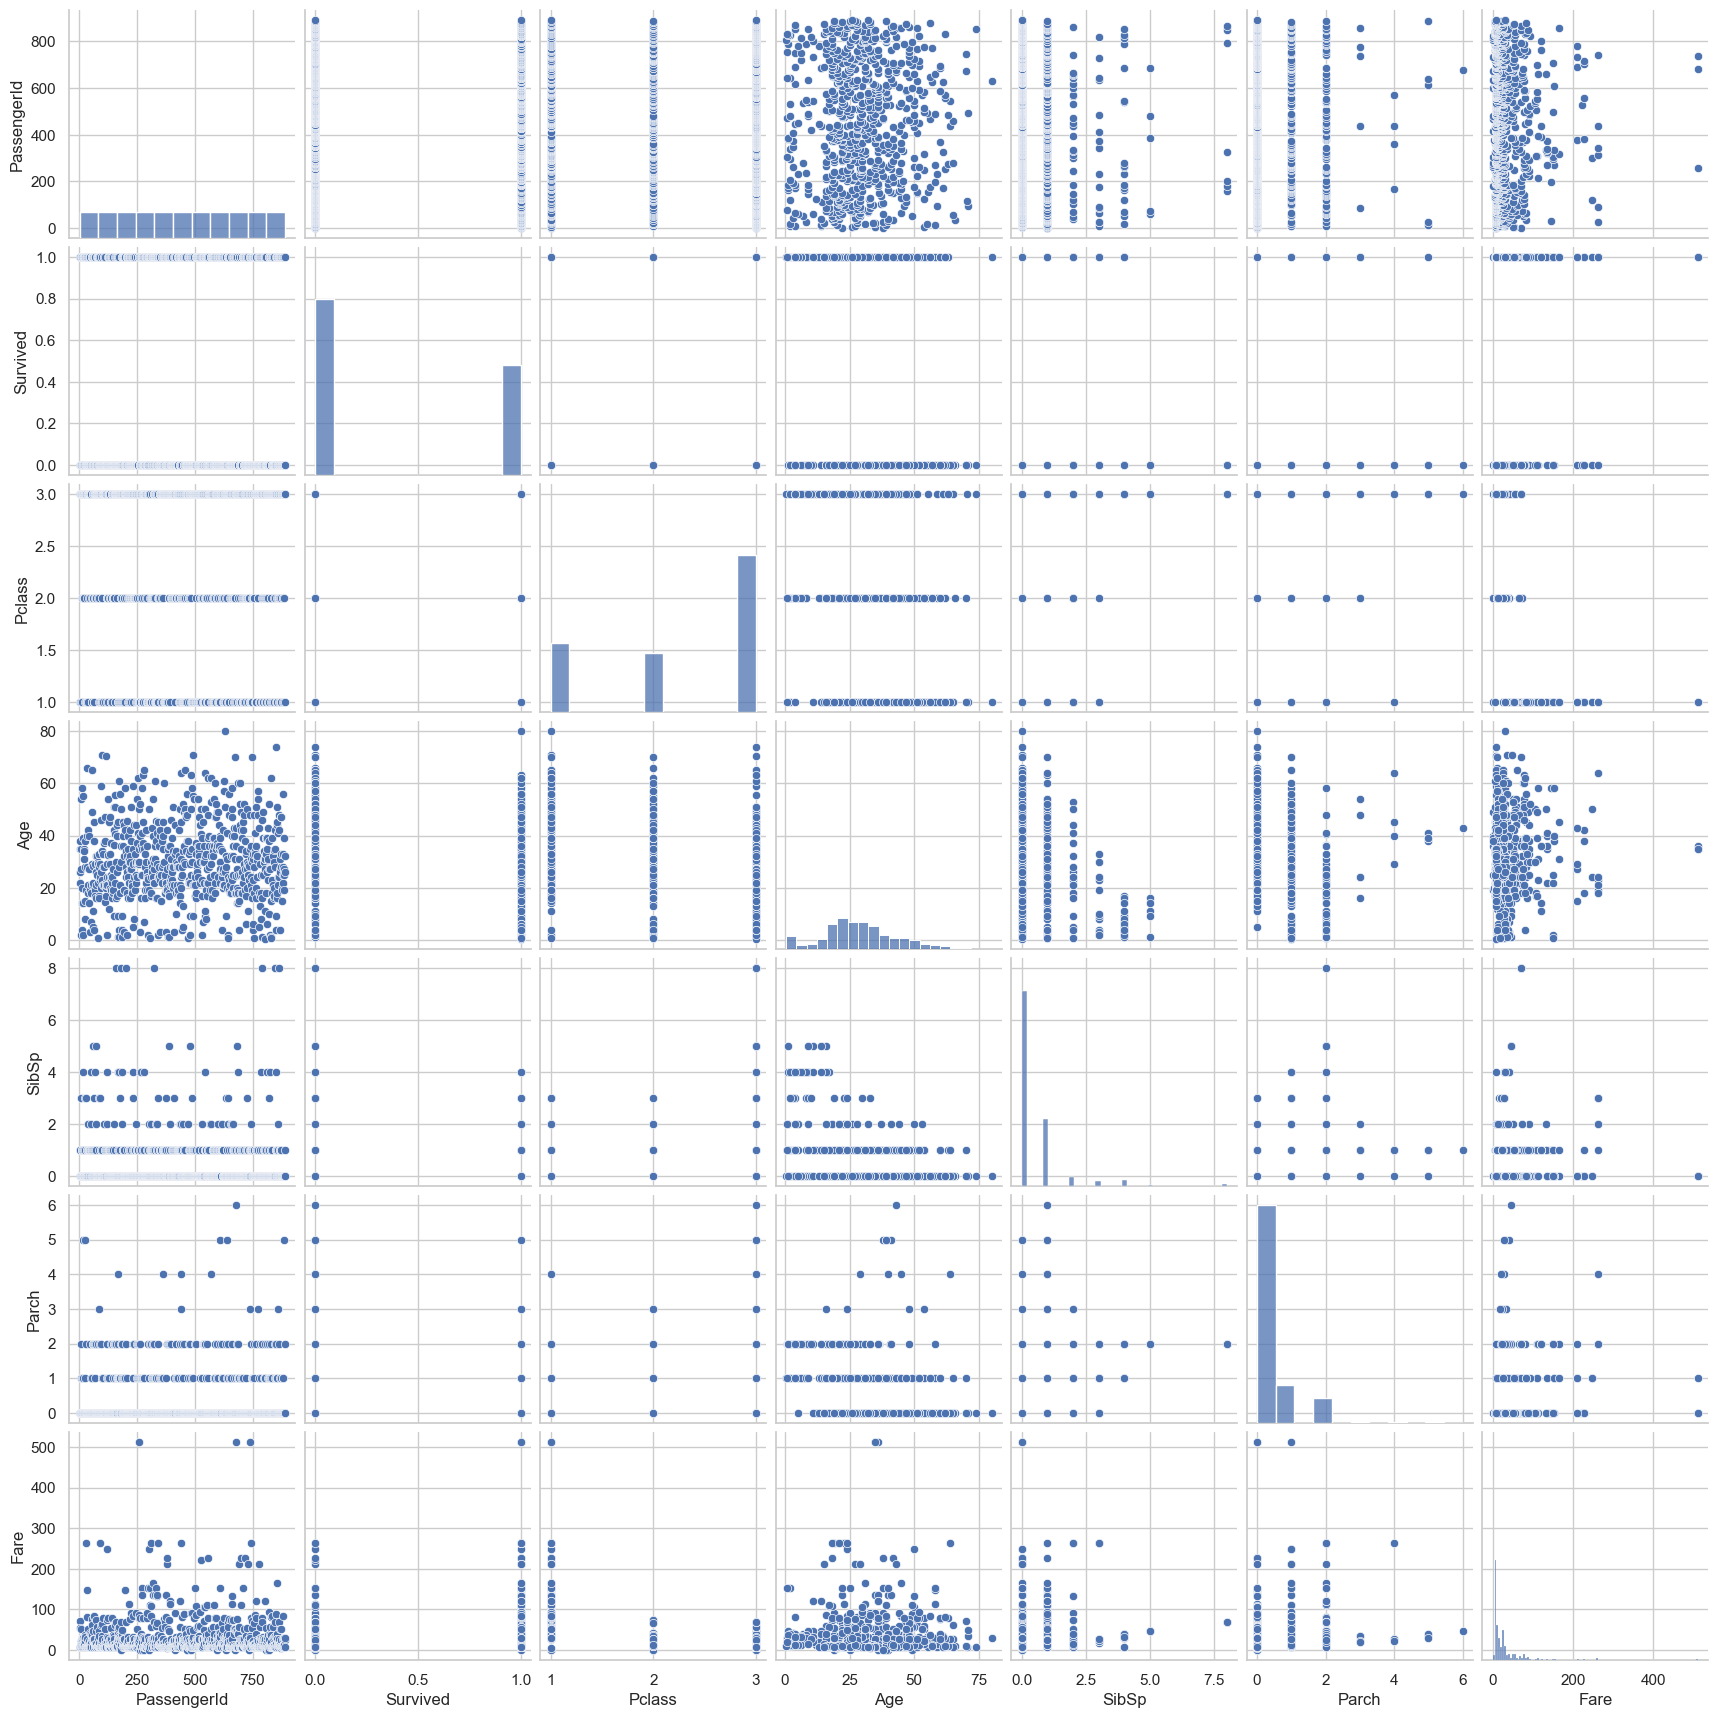

In [34]:
sns.pairplot(titanic_pd)
plt.show()

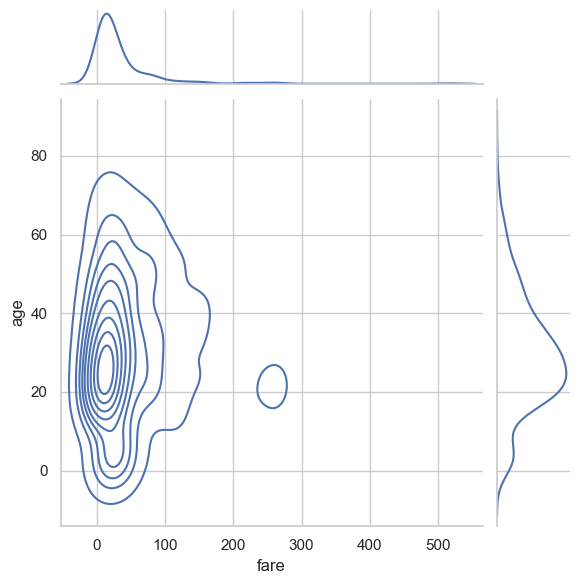

In [35]:
sns.jointplot(data=titanic_numeric.toPandas(), x="fare", y="age", kind="kde")
plt.show()

In [36]:
import numpy as np

In [51]:
rdd = spark.sparkContext.parallelize((i, np.random.randn()) for i in range(100000))

pyspark_df = rdd.toDF(["index", "value"])
pyspark_df.show(5)

+-----+--------------------+
|index|               value|
+-----+--------------------+
|    0| -1.0646825376223823|
|    1| -0.0330718738416527|
|    2|  1.1877814352852893|
|    3|-0.16895447123047672|
|    4|0.001851828652210...|
+-----+--------------------+
only showing top 5 rows



In [52]:
sample_df = pyspark_df.sample(fraction=0.01)


sample_pd = sample_df.toPandas()

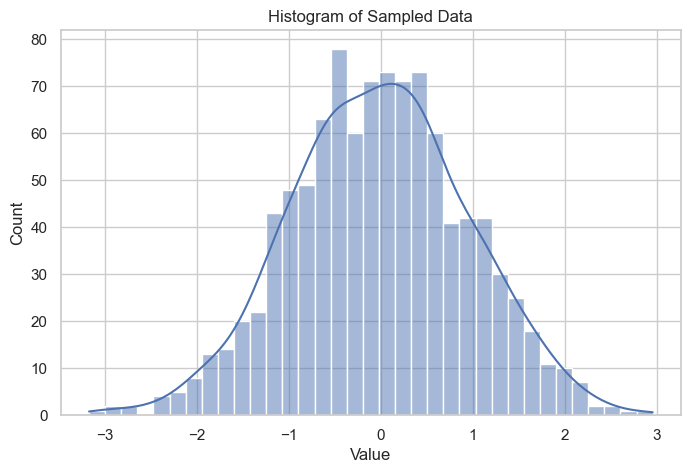

In [56]:
plt.figure(figsize=(8, 5))
sns.histplot(sample_pd, x="value", kde=True, bins=35)  

plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Histogram of Sampled Data")

plt.show()





In [66]:
agg_df = pyspark_df.groupBy(expr('FLOOR(value * 10) / 10 AS bin_value')).agg(count("value")).alias('count')
agg_df = agg_df.orderBy('bin_value', ascending=False)
agg_df.show()


+---------+------------+
|bin_value|count(value)|
+---------+------------+
|      4.9|           1|
|      4.6|           1|
|      4.2|           1|
|      4.1|           1|
|      4.0|           1|
|      3.9|           1|
|      3.8|           3|
|      3.7|           5|
|      3.6|           3|
|      3.5|          11|
|      3.4|          14|
|      3.3|          16|
|      3.2|          26|
|      3.1|          25|
|      3.0|          38|
|      2.9|          57|
|      2.8|          58|
|      2.7|         106|
|      2.6|         133|
|      2.5|         172|
+---------+------------+
only showing top 20 rows



In [71]:
agg_data = agg_df.toPandas()

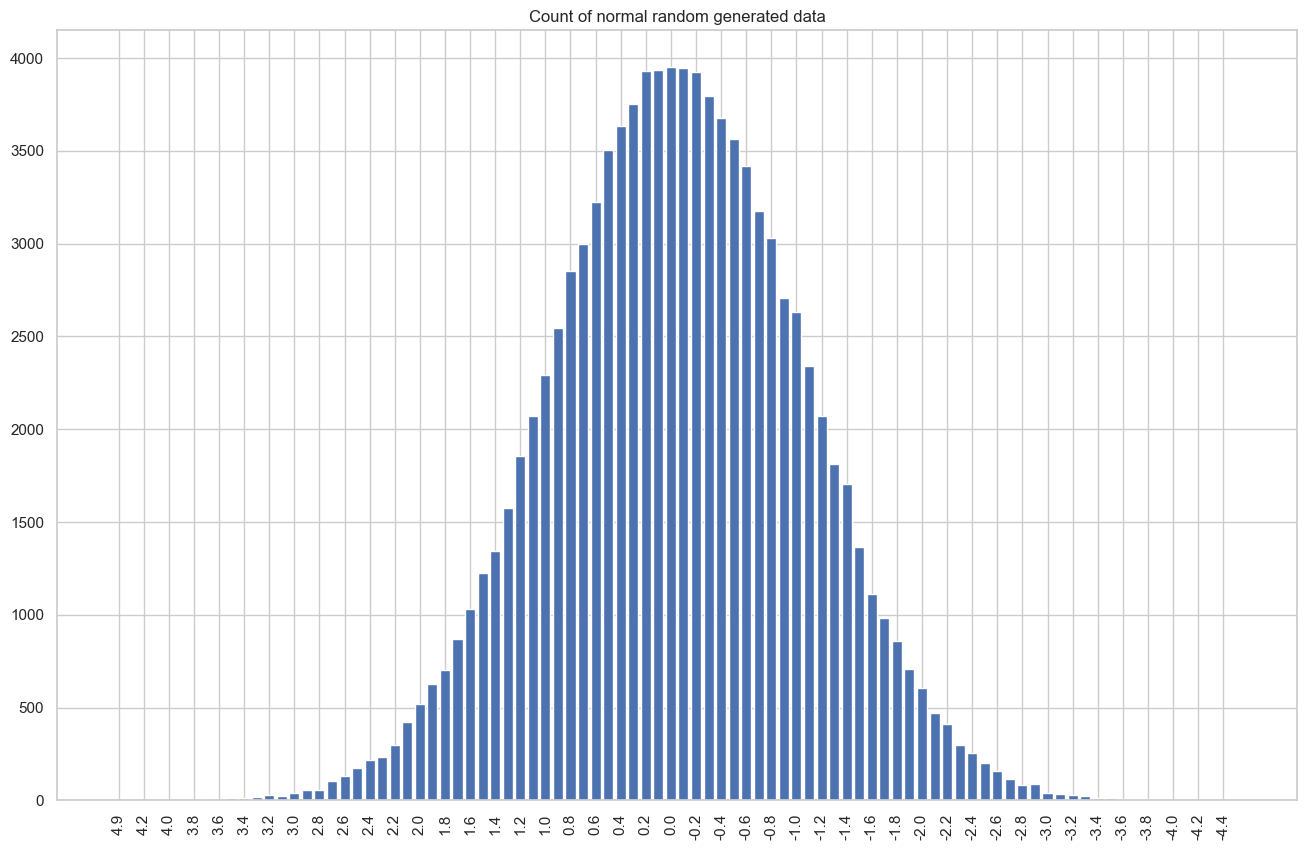

In [77]:
plt.figure(figsize=(16, 10))
plt.bar(agg_data["bin_value"].astype(str), agg_data["count(value)"])
plt.title("Count of normal random generated data")
plt.xticks(rotation=90)

ticks = plt.gca().get_xticks()  # Get current tick positions
ticks_to_show = ticks[::2]  # Take every second tick position
labels_to_show = [agg_data["bin_value"].astype(str).iloc[i] for i in range(0, len(agg_data), 2)]  # Select corresponding labels

plt.xticks(ticks_to_show, labels_to_show)
plt.show()

In [78]:
path = "/Users/tomdursley/Downloads/UK_Local_Authority_UTLA_COVID_Dataset.csv"  # Update this if the file is in a different directory
Covid_pd = pd.read_csv(path)

In [79]:
Covid_pd

,date,areaName,areaCode,newCasesByPublishDate,cumCasesByPublishDate,newDeaths28DaysByPublishDate,cumDeaths28DaysByPublishDate,cumDeaths28DaysByPublishDateRate,newDeaths28DaysByDeathDate,cumDeaths28DaysByDeathDate,cumDeaths28DaysByDeathDateRate
0,2020-03-28,Aberdeen City,S12000033,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.4
1,2020-03-29,Aberdeen City,S12000033,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.4
2,2020-03-30,Aberdeen City,S12000033,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.4
3,2020-03-31,Aberdeen City,S12000033,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.4
4,2020-04-01,Aberdeen City,S12000033,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.4
...,...,...,...,...,...,...,...,...,...,...,...
120136,2022-01-10,York,E06000014,416.0,41464.0,0.0,375.0,177.7,0.0,378.0,179.1
120137,2022-01-11,York,E06000014,445.0,41909.0,3.0,378.0,179.1,0.0,378.0,179.1
120138,2022-01-12,York,E06000014,403.0,42312.0,0.0,378.0,179.1,1.0,379.0,179.6
120139,2022-01-13,York,E06000014,267.0,42579.0,0.0,378.0,179.1,0.0,379.0,179.6
